# Experiment 1A2H

Randomly sample 2 raters N times. 
Evaluate automated scores against different pairs of raters. 
Show wide spread in r but more stable PRMSE. Hopefully it will be close to what we know to be true PRMSE. 

In [10]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import numpy as np

import itertools

from rsmtool.prmse_utils import compute_prmse

import json

%matplotlib inline

In [11]:
config = json.load(open('settings.json'))
N_responses = config['N_responses']
N_raters = config['N_raters']

In [12]:
df = pd.read_csv('../data/data.csv')
df['system'] = df['sys_7']

In [13]:
# generate all possible pairs of raters
raters = ['h_{}'.format(h) for h in range(1, N_raters+1)]
# we do the following to keep the array unidimensional
rater_pairs = ['{}+{}'.format(p[0], p[1]) for p in itertools.combinations(raters, 2)]

In [14]:
# randomly sample X pairs
N_pairs = 100
np.random.seed(100)
selected_pairs = np.random.choice(rater_pairs, N_pairs, replace=False)

In [15]:
# we make one long DF to speed up computation
data = []
for p in selected_pairs:
    (h1, h2) = p.split('+')
    df_p = pd.DataFrame({'pair': p,
                          'h1': df[h1],
                          'h2': df[h2],
                          'system': df['system']})
    data.append(df_p)
df_long = pd.concat(data)

In [16]:
# compute mean score
df_long['h_mean'] = (df_long['h1'] + df_long['h2'])/2

## Correlations

In [17]:
true_corr = pearsonr(df['system'], df['true'])[0]
true_corr

0.8093209148854923

In [18]:
# let's compute correlations
df_corr = df_long.groupby('pair').corr().unstack().sort_values(by=('h1', 'h2'))
df_corr.columns = ['_'.join(col) for col in df_corr.columns]
len(df_corr)

100

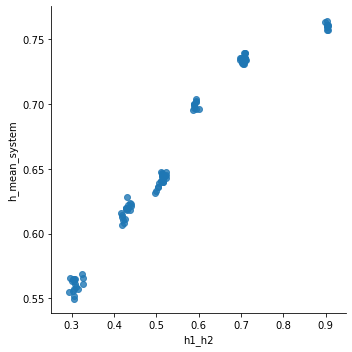

In [19]:
sns.lmplot(x='h1_h2', y='h_mean_system', data=df_corr, fit_reg=False)

## R2

In [20]:
# baseline: system r2 with true score.
true_r2 = r2_score(df['true'], df['system'])
true_r2

0.4767431000540935

In [21]:
df_r2 = pd.DataFrame(df_long.groupby('pair').apply(lambda x: r2_score(x['h_mean'], x['system'])))
df_r2.columns=['value']
df_r2['Metrics'] = 'R2_mean'

In [22]:
df_r2_h1 = pd.DataFrame(df_long.groupby('pair').apply(lambda x: r2_score(x['h1'], x['system'])))
df_r2_h1.columns=['value']
df_r2_h1['Metrics'] = 'R2_h1'

In [23]:
df_prmse_all = df_long.groupby('pair').apply(lambda x: compute_prmse(x,
                                                                 system_score_columns=['system'],
                                                                 h1_column='h1',
                                                                 h2_column='h2')).reset_index(level=1, drop=True)
df_prmse = df_prmse_all[['prmse_true']].copy()
df_prmse.columns = ['value']
df_prmse['Metrics'] = 'PRMSE'

In [24]:
df_res = pd.concat([df_r2, df_prmse], sort=True)

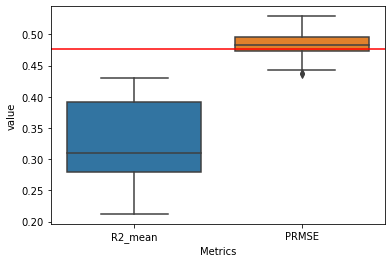

In [25]:
ax=sns.boxplot(x='Metrics', y='value', data=df_res)
ax.axhline(true_r2, color='red')

In [26]:
df_res.groupby('Metrics')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
Metrics,,,,,,,,
PRMSE,100.0,0.482192,0.019159,0.436578,0.473486,0.483084,0.496483,0.529058
R2_mean,100.0,0.324230,0.064487,0.212124,0.279896,0.310500,0.391212,0.430442


In [27]:
df_with_h = pd.merge(df_res, df_corr, right_index=True, left_index=True)
len(df_with_h)

200

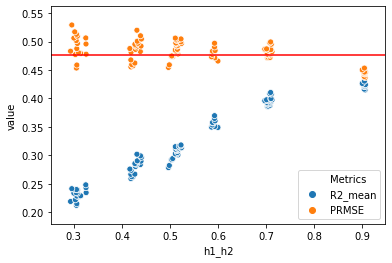

In [28]:
ax = sns.scatterplot(x='h1_h2', y='value', hue="Metrics", data=df_with_h.sort_values('value'))
ax.axhline(true_r2, color='red')